In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from darts import TimeSeries 
from darts.utils.utils import ModelMode, SeasonalityMode 
from darts.models import NaiveMean, ExponentialSmoothing
from darts.metrics import mae, mape

/Users/kelvinfoo/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
df = pd.read_csv('/Users/kelvinfoo/Desktop/AI Masters/Hospital Admission Time Series/hospital_admission.csv')
df = df.rename(columns = {'Data Series':'Date', 'Public Sector Hospital Admissions -> Alexandra Hospital (Number)': 'Alexandra Hospital', 
                     'Public Sector Hospital Admissions -> Changi General Hospital (Number)':'Changi General Hospital', 
                     'Public Sector Hospital Admissions -> Khoo Teck Puat Hospital (Number)':'Khoo Teck Puat Hospital', 
                     'Public Sector Hospital Admissions -> National University Hospital (Number)': 'National University Hospital', 
                     'Public Sector Hospital Admissions -> Sengkang General Hospital (Number)': 'Sengkang General Hospital'})

df['Date'] = pd.to_datetime(df['Date'])
df = df[['Date', 'Alexandra Hospital', 'Changi General Hospital', 'Khoo Teck Puat Hospital', 'National University Hospital', 'Sengkang General Hospital']]
df = df[df['Date'] >= '2020-01-01']

df['Alexandra Hospital'] = df['Alexandra Hospital'].astype('int64')
df['Changi General Hospital'] = df['Changi General Hospital'].astype('int64')
df['Khoo Teck Puat Hospital'] = df['Khoo Teck Puat Hospital'].astype('int64')
df['National University Hospital'] = df['National University Hospital'].astype('int64')
df['Sengkang General Hospital'] = df['Sengkang General Hospital'].astype('int64')
df.set_index('Date', inplace = True)

print(f"Shape of data: {df.shape}")
df.head()

Shape of data: (62, 5)


/var/folders/sz/zbv9dh196hl72cfhwv8ygplh0000gn/T/ipykernel_3155/2505176778.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


,Alexandra Hospital,Changi General Hospital,Khoo Teck Puat Hospital,National University Hospital,Sengkang General Hospital
Date,,,,,
2025-02-01,992,4592,3515,5843,4592
2025-01-01,1046,5023,3575,6026,4777
2024-12-01,1009,4966,3616,6076,4751
2024-11-01,971,4665,3369,6209,4467
2024-10-01,952,4930,3511,6318,4922


### **Splitting into Train, Validation and Test Sets**

In [8]:
df = df.sort_values(by = 'Date', ascending = True)

df_train = df[:58] 
df_test = df[58:]

### **Naive Mean Baseline Model**

In [11]:
hospitals = {
    "Alexandra Hospital": "alexandra",
    "Changi General Hospital": "cgh",
    "Khoo Teck Puat Hospital": "ktp",
    "National University Hospital": "nuh",
    "Sengkang General Hospital": "sgh"
}

pred_len =  len(df_test)

for hospital, code in hospitals.items():
    print(f"--- {hospital} ---")

    ts_train = TimeSeries.from_series(df_train[hospital])
    ts_test = TimeSeries.from_series(df_test[hospital])

    model = NaiveMean()
    model.fit(ts_train)
    forecast = model.predict(pred_len)

    forecast_test = forecast[-len(df_test): ]

    hospital_mae = mae(forecast_test, ts_test)
    hospital_mape = mape(forecast_test, ts_test)


    print(f"MAE (Test Only): {hospital_mae:.2f}")
    print(f"MAPE (Test Only): {hospital_mape:.2f}%\n")

--- Alexandra Hospital ---
MAE (Test Only): 185.64
MAPE (Test Only): 22.67%

--- Changi General Hospital ---
MAE (Test Only): 439.03
MAPE (Test Only): 10.04%

--- Khoo Teck Puat Hospital ---
MAE (Test Only): 92.23
MAPE (Test Only): 2.56%

--- National University Hospital ---
MAE (Test Only): 375.64
MAPE (Test Only): 6.63%

--- Sengkang General Hospital ---
MAE (Test Only): 674.04
MAPE (Test Only): 16.97%



### **Holt-Winter's Baseline Model**

--- Alexandra Hospital ---
MAE (Test Only): 57.44
MAPE (Test Only): 6.14%

--- Changi General Hospital ---
MAE (Test Only): 117.23
MAPE (Test Only): 2.49%

--- Khoo Teck Puat Hospital ---
MAE (Test Only): 238.43
MAPE (Test Only): 7.57%

--- National University Hospital ---
MAE (Test Only): 180.78
MAPE (Test Only): 2.88%

--- Sengkang General Hospital ---
MAE (Test Only): 98.41
MAPE (Test Only): 2.16%



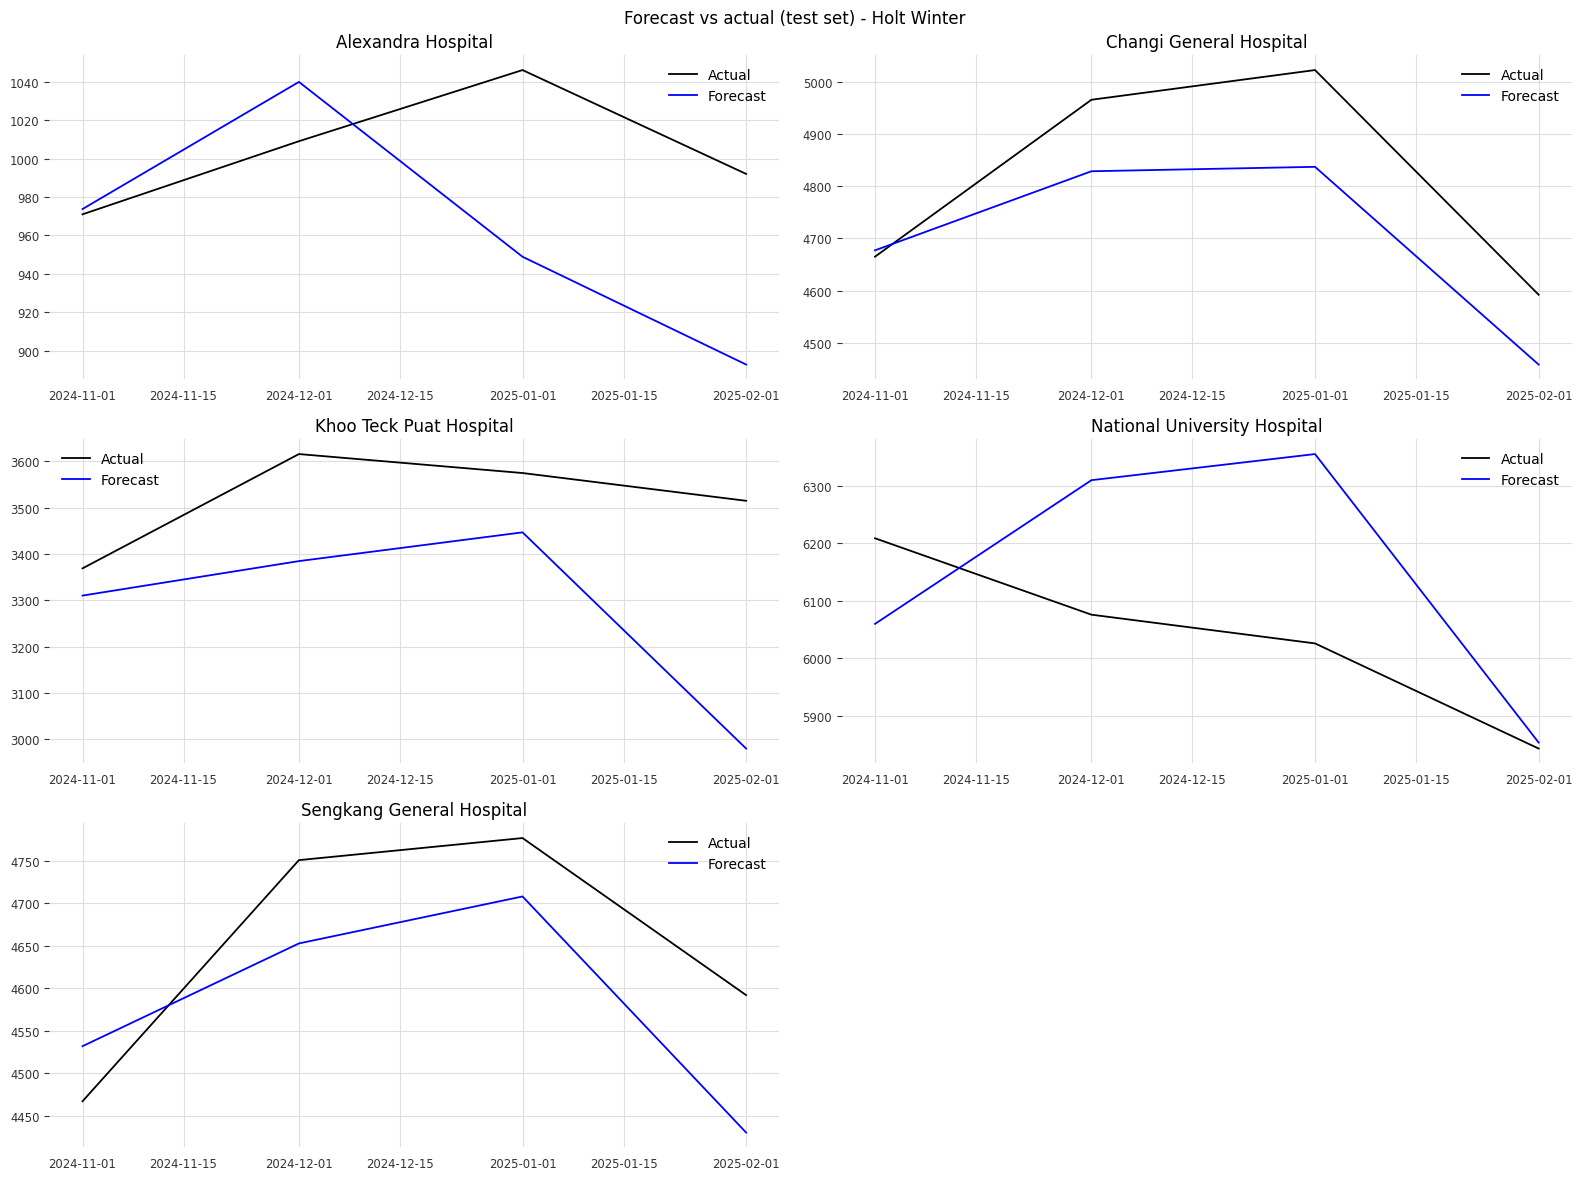

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (hospital, code) in enumerate(hospitals.items()):
    print(f"--- {hospital} ---")

    ts_train = TimeSeries.from_series(df_train[hospital])
    ts_test = TimeSeries.from_series(df_test[hospital])

    model = ExponentialSmoothing(trend = ModelMode.ADDITIVE, seasonal = SeasonalityMode.ADDITIVE)
    model.fit(ts_train)
    forecast = model.predict(pred_len)
    forecast_test = forecast[-len(df_test): ]

    axes[i].plot(ts_test.time_index, ts_test.values(), label='Actual', color='black')
    axes[i].plot(forecast_test.time_index, forecast_test.values(), label='Forecast', color='blue')
    axes[i].set_title(hospital)
    axes[i].legend()
    axes[i].grid(True)

    hospital_mae = mae(forecast_test, ts_test)
    hospital_mape = mape(forecast_test, ts_test)

    print(f"MAE (Test Only): {hospital_mae:.2f}")
    print(f"MAPE (Test Only): {hospital_mape:.2f}%\n")

if len(hospitals) < len(axes):
    fig.delaxes(axes[-1])

plt.suptitle('Forecast vs actual (test set) - Holt Winter')
plt.tight_layout()
plt.show()